In [7]:
library(data.table)
combined_DAP_JAN_028_ATAC=fread("~/github_reproducibility/table_S2.csv")
all_gene_ids=unique(combined_DAP_JAN_028_ATAC %>%
filter(p_weight < 0.05 / 230000)%>%
pull(gene_ID))

In [8]:
length(all_gene_ids)


[1] 50114

In [9]:
palantir_erythroid_peaks_from_NT=read.table('~/JAN_028/peak_communities_JAN_028_NT_cells_post_palantir.csv',header=TRUE,sep=',')
palantir_erythroid_peaks_from_NT=palantir_erythroid_peaks_from_NT %>%
filter(X0 %in% c(2,10,18,23,25))%>%
pull(X)

In [10]:
length(palantir_erythroid_peaks_from_NT)


[1] 29555

In [11]:
length(intersect(all_gene_ids, palantir_erythroid_peaks_from_NT))


[1] 8690

In [13]:
`%notin%` <- Negate(`%in%`)

length(which(all_gene_ids %notin% palantir_erythroid_peaks_from_NT))


[1] 41424

In [14]:
length(which(palantir_erythroid_peaks_from_NT %notin% all_gene_ids))


[1] 20865

Intersect between two annotations:

In [ ]:
folder1="/home/jupyter/github_reproducibility/ldsc_analysis_peaks_correlated_with_erythroid_differentiation"
folder2="/home/jupyter/github_reproducibility/ldsc_analysis_TF_sensitive_peaks_NO_BASE"
folder3="/home/jupyter/github_reproducibility/ldsc_analysis_INTERSECT_peaks_correlated_with_erythroid_differentiation_and_TF_sensitive_peaks"
lastColumnName="INTERSECT_peaks_correlated_with_erythroid_differentiation_and_TF_sensitive_peaks"

mkdir -p "$folder3"
cd "$folder3"
rm *
for i in {1..22}
do
    echo $i
    file1="$folder1/custom_annot${i}.annot.gz"
    file2="$folder2/custom_annot${i}.annot.gz"
    outputFile="$folder3/custom_annot${i}.annot.gz"
    awk -v colName="$lastColumnName" 'BEGIN{OFS="\t"} NR==FNR{if(NR==1){print $1,$2,$3,$4,colName}else{a[$1,$2,$3]=$5}} NR!=FNR{if(FNR>1)print $1,$2,$3,$4,((a[$1,$2,$3]==1 && $5==1)?1:0)}' <(zcat "$file1") <(zcat "$file2") | gzip > "$outputFile"
done

echo "Processing complete."


Unique on annotation 1 but not on annotation 2:

In [ ]:
folder1="/home/jupyter/github_reproducibility/ldsc_analysis_peaks_correlated_with_erythroid_differentiation"
folder2="/home/jupyter/github_reproducibility/ldsc_analysis_TF_sensitive_peaks_NO_BASE"
folder3="/home/jupyter/github_reproducibility/ldsc_analysis_UNIQUE_peaks_correlated_with_erythroid_differentiation_NOT_IN_TF_sensitive"

lastColumnName="UNIQUE_peaks_correlated_with_erythroid_differentiation_NOT_IN_TF_sensitive"

mkdir -p "$folder3"
cd $folder3
rm *
for i in {1..22}
do
    echo $i
    file1="$folder1/custom_annot${i}.annot.gz"
    file2="$folder2/custom_annot${i}.annot.gz"
    outputFile="$folder3/custom_annot${i}.annot.gz"

    awk -v colName="$lastColumnName" 'BEGIN{OFS="\t"} 
    NR==FNR {
        if(NR==1){print $1,$2,$3,$4,colName} 
        else {a[$1,$2,$3]=$5}
        next
    } 
    {
        if(FNR==1) next; # Skip header of the second file
        print $1,$2,$3,$4,((a[$1,$2,$3]==1 && $5!=1) ? 1 : 0)
    }' <(zcat "$file1") <(zcat "$file2") | gzip > "$outputFile"
done

Unique on annotation 2 but not on annotation 1:

In [ ]:
folder1="/home/jupyter/github_reproducibility/ldsc_analysis_peaks_correlated_with_erythroid_differentiation"
folder2="/home/jupyter/github_reproducibility/ldsc_analysis_TF_sensitive_peaks_NO_BASE"
folder3="/home/jupyter/github_reproducibility/ldsc_analysis_UNIQUE_TF_sensitive_NOT_IN_peaks_correlated_with_erythroid_differentiation"

lastColumnName="UNIQUE_TF_sensitive_NOT_IN_peaks_correlated_with_erythroid_differentiation"

mkdir -p "$folder3"
cd $folder3
rm *
for i in {1..22}
do
    echo $i
    file1="$folder1/custom_annot${i}.annot.gz"
    file2="$folder2/custom_annot${i}.annot.gz"
    outputFile="$folder3/custom_annot${i}.annot.gz"

    awk -v colName="$lastColumnName" 'BEGIN{OFS="\t"} 
    NR==FNR {
        if(NR==1){print $1,$2,$3,$4,colName} 
        else {a[$1,$2,$3]=$5}
        next
    } 
    {
        if(FNR==1) next; # Skip header of the second file
        print $1,$2,$3,$4,((a[$1,$2,$3]!=1 && $5==1) ? 1 : 0)
    }' <(zcat "$file1") <(zcat "$file2") | gzip > "$outputFile"
done

Copy files to the bucket:

In [ ]:
cd /home/jupyter/github_reproducibility/ldsc_analysis_INTERSECT_peaks_correlated_with_erythroid_differentiation_and_TF_sensitive_peaks/
gsutil cp *annot.gz gs://bucket_path_1/

cd /home/jupyter/JAN_028/ldsc_analysis_UNIQUE_peaks_correlated_with_erythroid_differentiation_NOT_IN_TF_sensitive/
gsutil cp *annot.gz gs://bucket_path_2/

cd /home/jupyter/JAN_028/ldsc_analysis_UNIQUE_TF_sensitive_NOT_IN_peaks_correlated_with_erythroid_differentiation/
gsutil cp *annot.gz gs://bucket_path_3/


Run WDL WDL_LDSC in Terra.bio

Next, copy back the results from the WDL output into a folder

In [ ]:
mkdir /output/path/post_ldsc_files_1/
cd /output/path/post_ldsc_files_1/
gsutil cp gs://bucket_path_1_POST_LDSC/* .
for file in *.tar.gz; do
    tar -zxvf "$file"
done


And you need these files too that you uploaded to run the WDL

In [ ]:
cd local_files/
gsutil cp gs://bucket_path_1/* .



In [ ]:
mkdir /output/path/post_ldsc_files_1/
cd /output/path/post_ldsc_files_1/

conda activate ldsc
ldsc_path="/home/jmartinr/utilities/ldsc/ldsc.py"

sumstats_dir="/home/jmartinr/ldsc_vuckovic/output"

output_dir='/output/path/post_ldsc_files_1/'
ref_ld_chr_baseline="/home/jmartinr/ldsc_vuckovic/data/1000G_EUR_Phase3_baseline/baseline."
ref_ld_chr_responsive="/output/path/post_ldsc_files_1/custom_annot."
w_ld_chr="/home/jmartinr/ldsc_vuckovic/data/weights_hm3_no_hla/weights."
frqfile_chr="/home/jmartinr/ldsc_vuckovic/data/1000G_Phase3_frq/1000G.EUR.QC."

declare -a files=(
    "BCX2_RBC_EA_GWAMA"
  "BCX2_HGB_EA_GWAMA"
  "BCX2_HCT_EA_GWAMA"
  "BCX2_MCH_EA_GWAMA"
  "BCX2_MCV_EA_GWAMA"
  "BCX2_MCHC_EA_GWAMA"
  "BCX2_RDW_EA_GWAMA"
  "BCX2_WBC_EA_GWAMA"
  "BCX2_NEU_EA_GWAMA"
  "BCX2_LYM_EA_GWAMA"
  "BCX2_MON_EA_GWAMA"
  "BCX2_BAS_EA_GWAMA"
  "BCX2_EOS_EA_GWAMA"
  "BCX2_PLT_EA_GWAMA"
  "BCX2_MPV_EA_GWAMA"
)


for file_basename in "${files[@]}"; do
  sumstats_file="${sumstats_dir}/${file_basename}.sumstats.gz"
    
python $ldsc_path \
  --h2 $sumstats_file \
  --ref-ld-chr /output/path/post_ldsc_files_1/local_files/custom_annot,/home/jmartinr/ldsc_vuckovic/data/1000G_EUR_Phase3_baseline/baseline. \
  --w-ld-chr $w_ld_chr \
    --overlap-annot \
  --frqfile-chr $frqfile_chr \
  --out "${output_dir}/${file_basename}ldsc_analysis_INTERSECT_peaks_correlated_with_erythroid_differentiation_and_TF_sensitive_peaks_POST_LDSC" > "${output_dir}/${file_basename}ldsc_analysis_INTERSECT_peaks_correlated_with_erythroid_differentiation_and_TF_sensitive_peaks_POST_LDSC.log" 2>&1 &

done

wait

echo "All LDSC analyses have been run in parallel."

In [ ]:
#!/bin/bash

LOG_DIR="/output/path/post_ldsc_files_1/"
OUTPUT_FILE="ldsc_analysis_INTERSECT_peaks_correlated_with_erythroid_differentiation_and_TF_sensitive_peaks_extracted_data.csv"
cd $LOG_DIR

echo "Trait,Enrichment,Enrichment Std Error" > "$OUTPUT_FILE"

for file in "$LOG_DIR"/*_EA_GWAMAldsc_analysis_INTERSECT_peaks_correlated_with_erythroid_differentiation_and_TF_sensitive_peaks_POST_LDSC.results; do
    trait=$(basename "$file" | sed -E 's/BCX2_(.*)_EA_GWAMAldsc_analysis_INTERSECT_peaks_correlated_with_erythroid_differentiation_and_TF_sensitive_peaks_POST_LDSC.results/\1/')

    readarray -t enrichment_data < <(tail -n +2 "$file" | head -1)
    enrichment=$(echo "${enrichment_data[0]}" | awk '{print $5}')
    enrichment_std_error=$(echo "${enrichment_data[0]}" | awk '{print $6}')

    echo "$trait,$enrichment,$enrichment_std_error" >> "$OUTPUT_FILE"
done

echo "Data extraction complete. Output saved to $OUTPUT_FILE."

Do the same thing for any other annotation.

In [3]:
output_folder='~/0_perturb_multiome_manuscript_figures/'

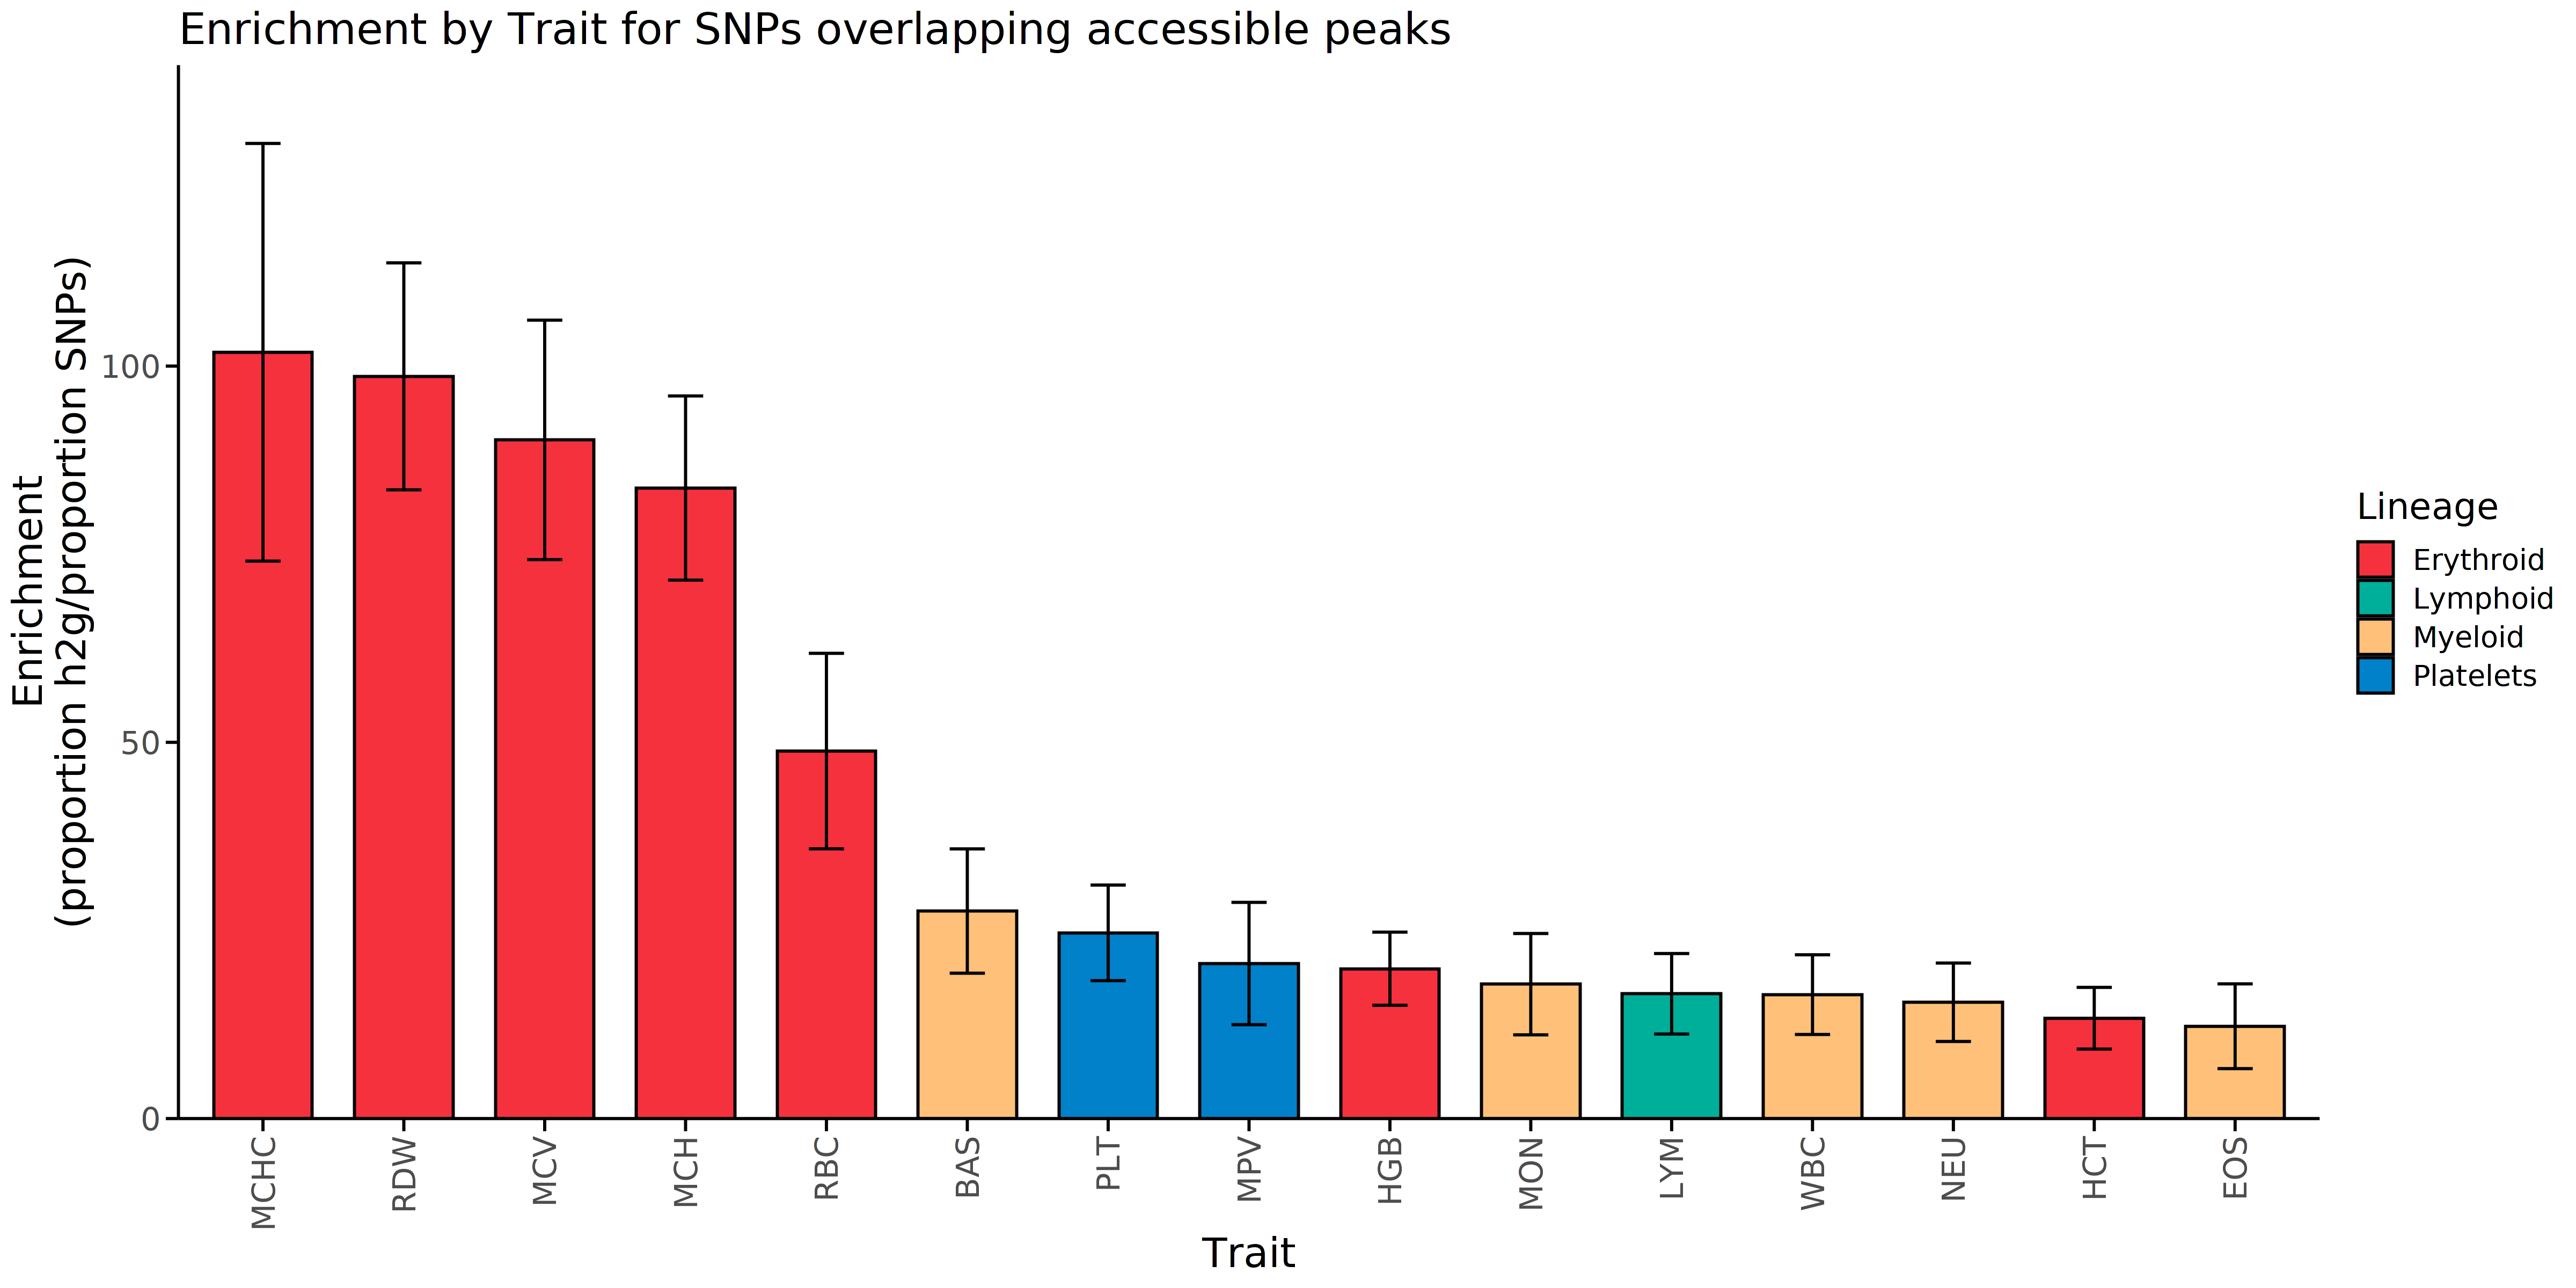

In [23]:
width=16
height=8
figure_name='INTERSECT_peaks_correlated_with_erythroid_differentiation_and_TF_sensitive_peaks.pdf'
options(repr.plot.width = width, repr.plot.height = height, repr.plot.res = 300)

data=read.table("/output/path/post_ldsc_files_1/ldsc_analysis_INTERSECT_peaks_correlated_with_erythroid_differentiation_and_TF_sensitive_peaks_extracted_data.csv",sep=',',header=TRUE)
library(ggplot2)
library(dplyr)
library(BuenColors)

colnames(data)[1]='Trait'
colnames(data)[2]='Enrichment_2'
colnames(data)[3]='Enrichment_se'

data$Lineage <- ifelse(grepl('LYM', data$Trait), 'Lymphoid',
                  ifelse(grepl('RBC|HGB|HCT|MCH|MCV|MCHC|RDW', data$Trait), 'Erythroid',
                  ifelse(grepl('WBC|NEU|MON|BAS|EOS', data$Trait), 'Myeloid',
                  ifelse(grepl('PLT|MPV', data$Trait), 'Platelets', 'Unknown'))))

responsive_order <- data %>%
  arrange(desc(Enrichment_2)) %>%
  .$Trait

data$Trait <- factor(data$Trait, levels = responsive_order)

bueno_colors <- c('Erythroid' = jdb_color_map(c("MEP")),
                  'Myeloid' = jdb_color_map(c("CMP")),
                  'Lymphoid' = jdb_color_map(c("LMPP")), # New color for Lymphoid
                  'Platelets' = jdb_color_map(c("CD4")))

p <- ggplot(data, aes(x = Trait, y = Enrichment_2, fill = Lineage)) +
  geom_bar(color='black',stat = "identity", position = position_dodge(), width = 0.7) +
 geom_errorbar(aes(ymin = Enrichment_2+Enrichment_se, ymax = Enrichment_2-Enrichment_se), 
                position = position_dodge(width = 0.7), 
                width = 0.25) +
  #facet_wrap(~Perturbation_Type, dir = "v", scales = 'free_x', labeller = labeller(Perturbation_Type = c('perturbation_responsive' = 'Peaks responsive to perturbation', 'non_responsive' = 'Peaks not responsive to perturbation'))) +
  scale_fill_manual(values = bueno_colors) +
  labs(title = 'Enrichment by Trait for SNPs overlapping accessible peaks', x = 'Trait', y = 'Enrichment\n(proportion h2g/proportion SNPs)') +
  theme_minimal() +
  theme(
    text = element_text(size = 16),
    axis.title = element_text(size = 18),
    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 14),
    axis.text.y = element_text(size = 14),
    panel.background = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.ticks = element_line(color = "black", size = 0.5), 
    axis.ticks.length = unit(2, "mm"),
    axis.line = element_line(color = "black"),
    strip.text = element_text(size = 16),
    strip.background = element_blank()
  )+ scale_y_continuous(expand = c(0, 0),limits = c(0,140))

print(p)

ggsave(paste(output_folder,figure_name,sep=""),dpi = 600, width = width, height = height)


In [24]:
mean(data %>%
filter(Lineage == 'Erythroid') %>%
pull(Enrichment_2))

[1] 65.22205

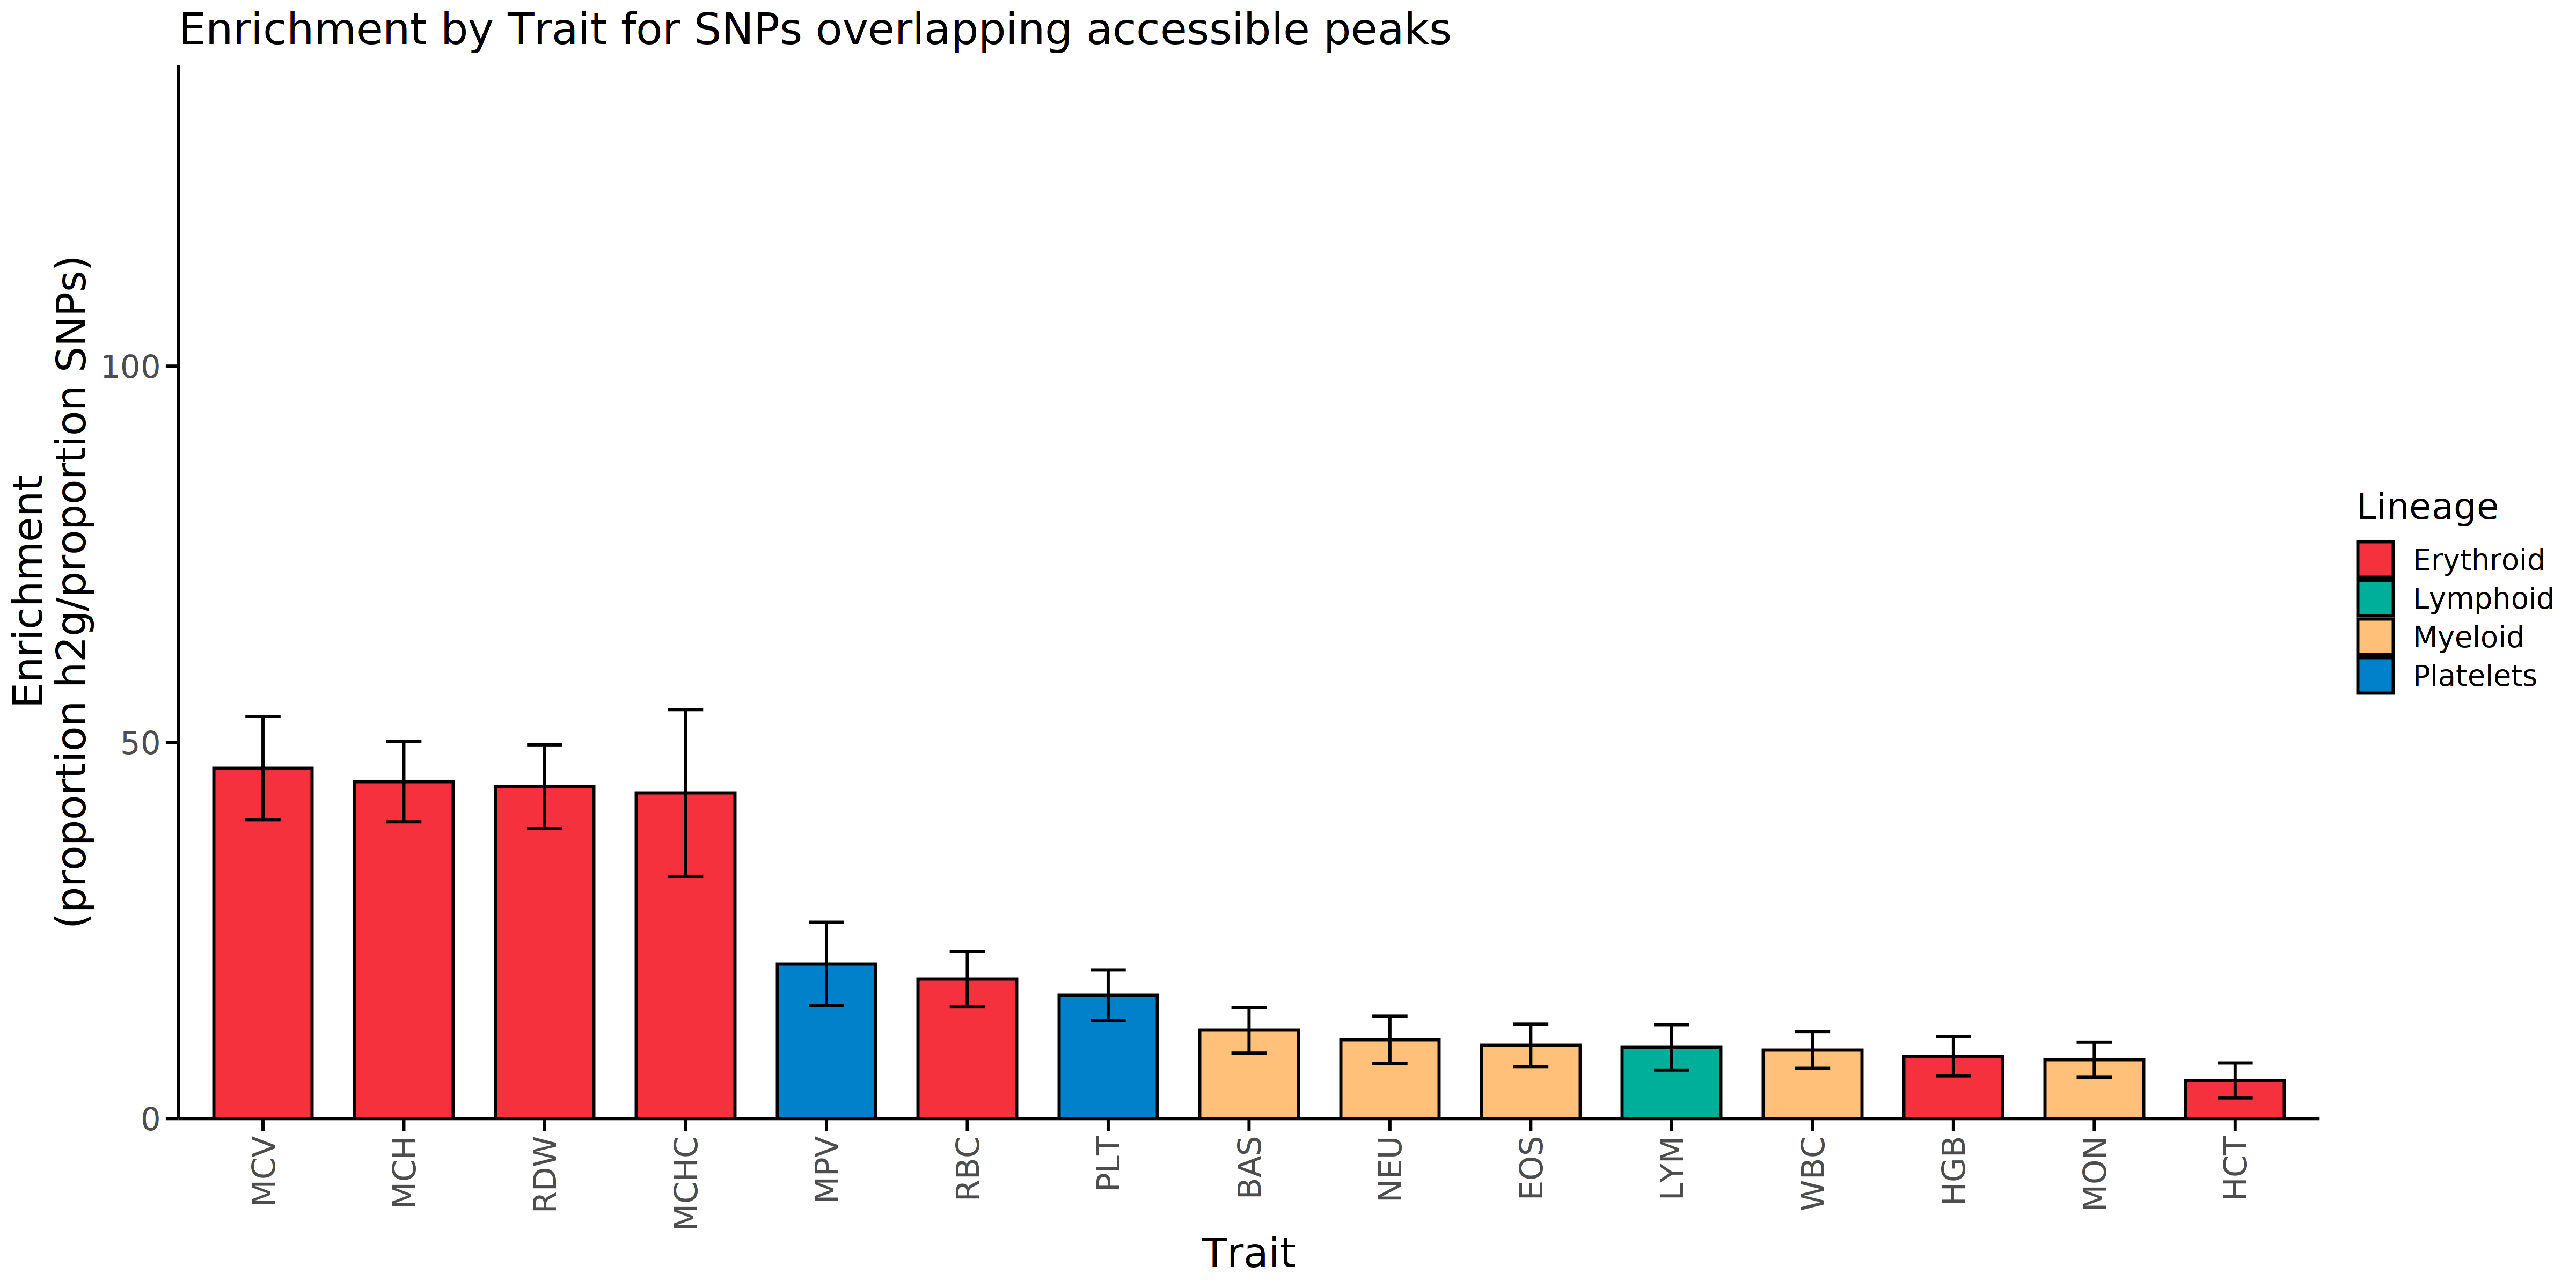

In [18]:
width=16
height=8
figure_name='UNIQUE_peaks_correlated_with_erythroid_differentiation_NOT_IN_TF_sensitive.pdf'
options(repr.plot.width = width, repr.plot.height = height, repr.plot.res = 300)

data=read.table("/output/path/post_ldsc_files_2/ldsc_analysis_UNIQUE_peaks_correlated_with_erythroid_differentiation_NOT_IN_TF_sensitive_extracted_data.csv",sep=',',header=TRUE)
library(ggplot2)
library(dplyr)
library(BuenColors)

colnames(data)[1]='Trait'
colnames(data)[2]='Enrichment_2'
colnames(data)[3]='Enrichment_se'

data$Lineage <- ifelse(grepl('LYM', data$Trait), 'Lymphoid',
                  ifelse(grepl('RBC|HGB|HCT|MCH|MCV|MCHC|RDW', data$Trait), 'Erythroid',
                  ifelse(grepl('WBC|NEU|MON|BAS|EOS', data$Trait), 'Myeloid',
                  ifelse(grepl('PLT|MPV', data$Trait), 'Platelets', 'Unknown'))))

responsive_order <- data %>%
  arrange(desc(Enrichment_2)) %>%
  .$Trait

data$Trait <- factor(data$Trait, levels = responsive_order)

bueno_colors <- c('Erythroid' = jdb_color_map(c("MEP")),
                  'Myeloid' = jdb_color_map(c("CMP")),
                  'Lymphoid' = jdb_color_map(c("LMPP")), # New color for Lymphoid
                  'Platelets' = jdb_color_map(c("CD4")))

p <- ggplot(data, aes(x = Trait, y = Enrichment_2, fill = Lineage)) +
  geom_bar(color='black',stat = "identity", position = position_dodge(), width = 0.7) +
 geom_errorbar(aes(ymin = Enrichment_2+Enrichment_se, ymax = Enrichment_2-Enrichment_se), 
                position = position_dodge(width = 0.7), 
                width = 0.25) +
  #facet_wrap(~Perturbation_Type, dir = "v", scales = 'free_x', labeller = labeller(Perturbation_Type = c('perturbation_responsive' = 'Peaks responsive to perturbation', 'non_responsive' = 'Peaks not responsive to perturbation'))) +
  scale_fill_manual(values = bueno_colors) +
  labs(title = 'Enrichment by Trait for SNPs overlapping accessible peaks', x = 'Trait', y = 'Enrichment\n(proportion h2g/proportion SNPs)') +
  theme_minimal() +
  theme(
    text = element_text(size = 16),
    axis.title = element_text(size = 18),
    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 14),
    axis.text.y = element_text(size = 14),
    panel.background = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.ticks = element_line(color = "black", size = 0.5),
    axis.ticks.length = unit(2, "mm"),
    axis.line = element_line(color = "black"),
    strip.text = element_text(size = 16),
    strip.background = element_blank()
  )+ scale_y_continuous(expand = c(0, 0),limits = c(0,140))

print(p)

ggsave(paste(output_folder,figure_name,sep=""),dpi = 600, width = width, height = height)


In [22]:
mean(data %>%
filter(Lineage == 'Erythroid') %>%
pull(Enrichment_2))

[1] 30.08557

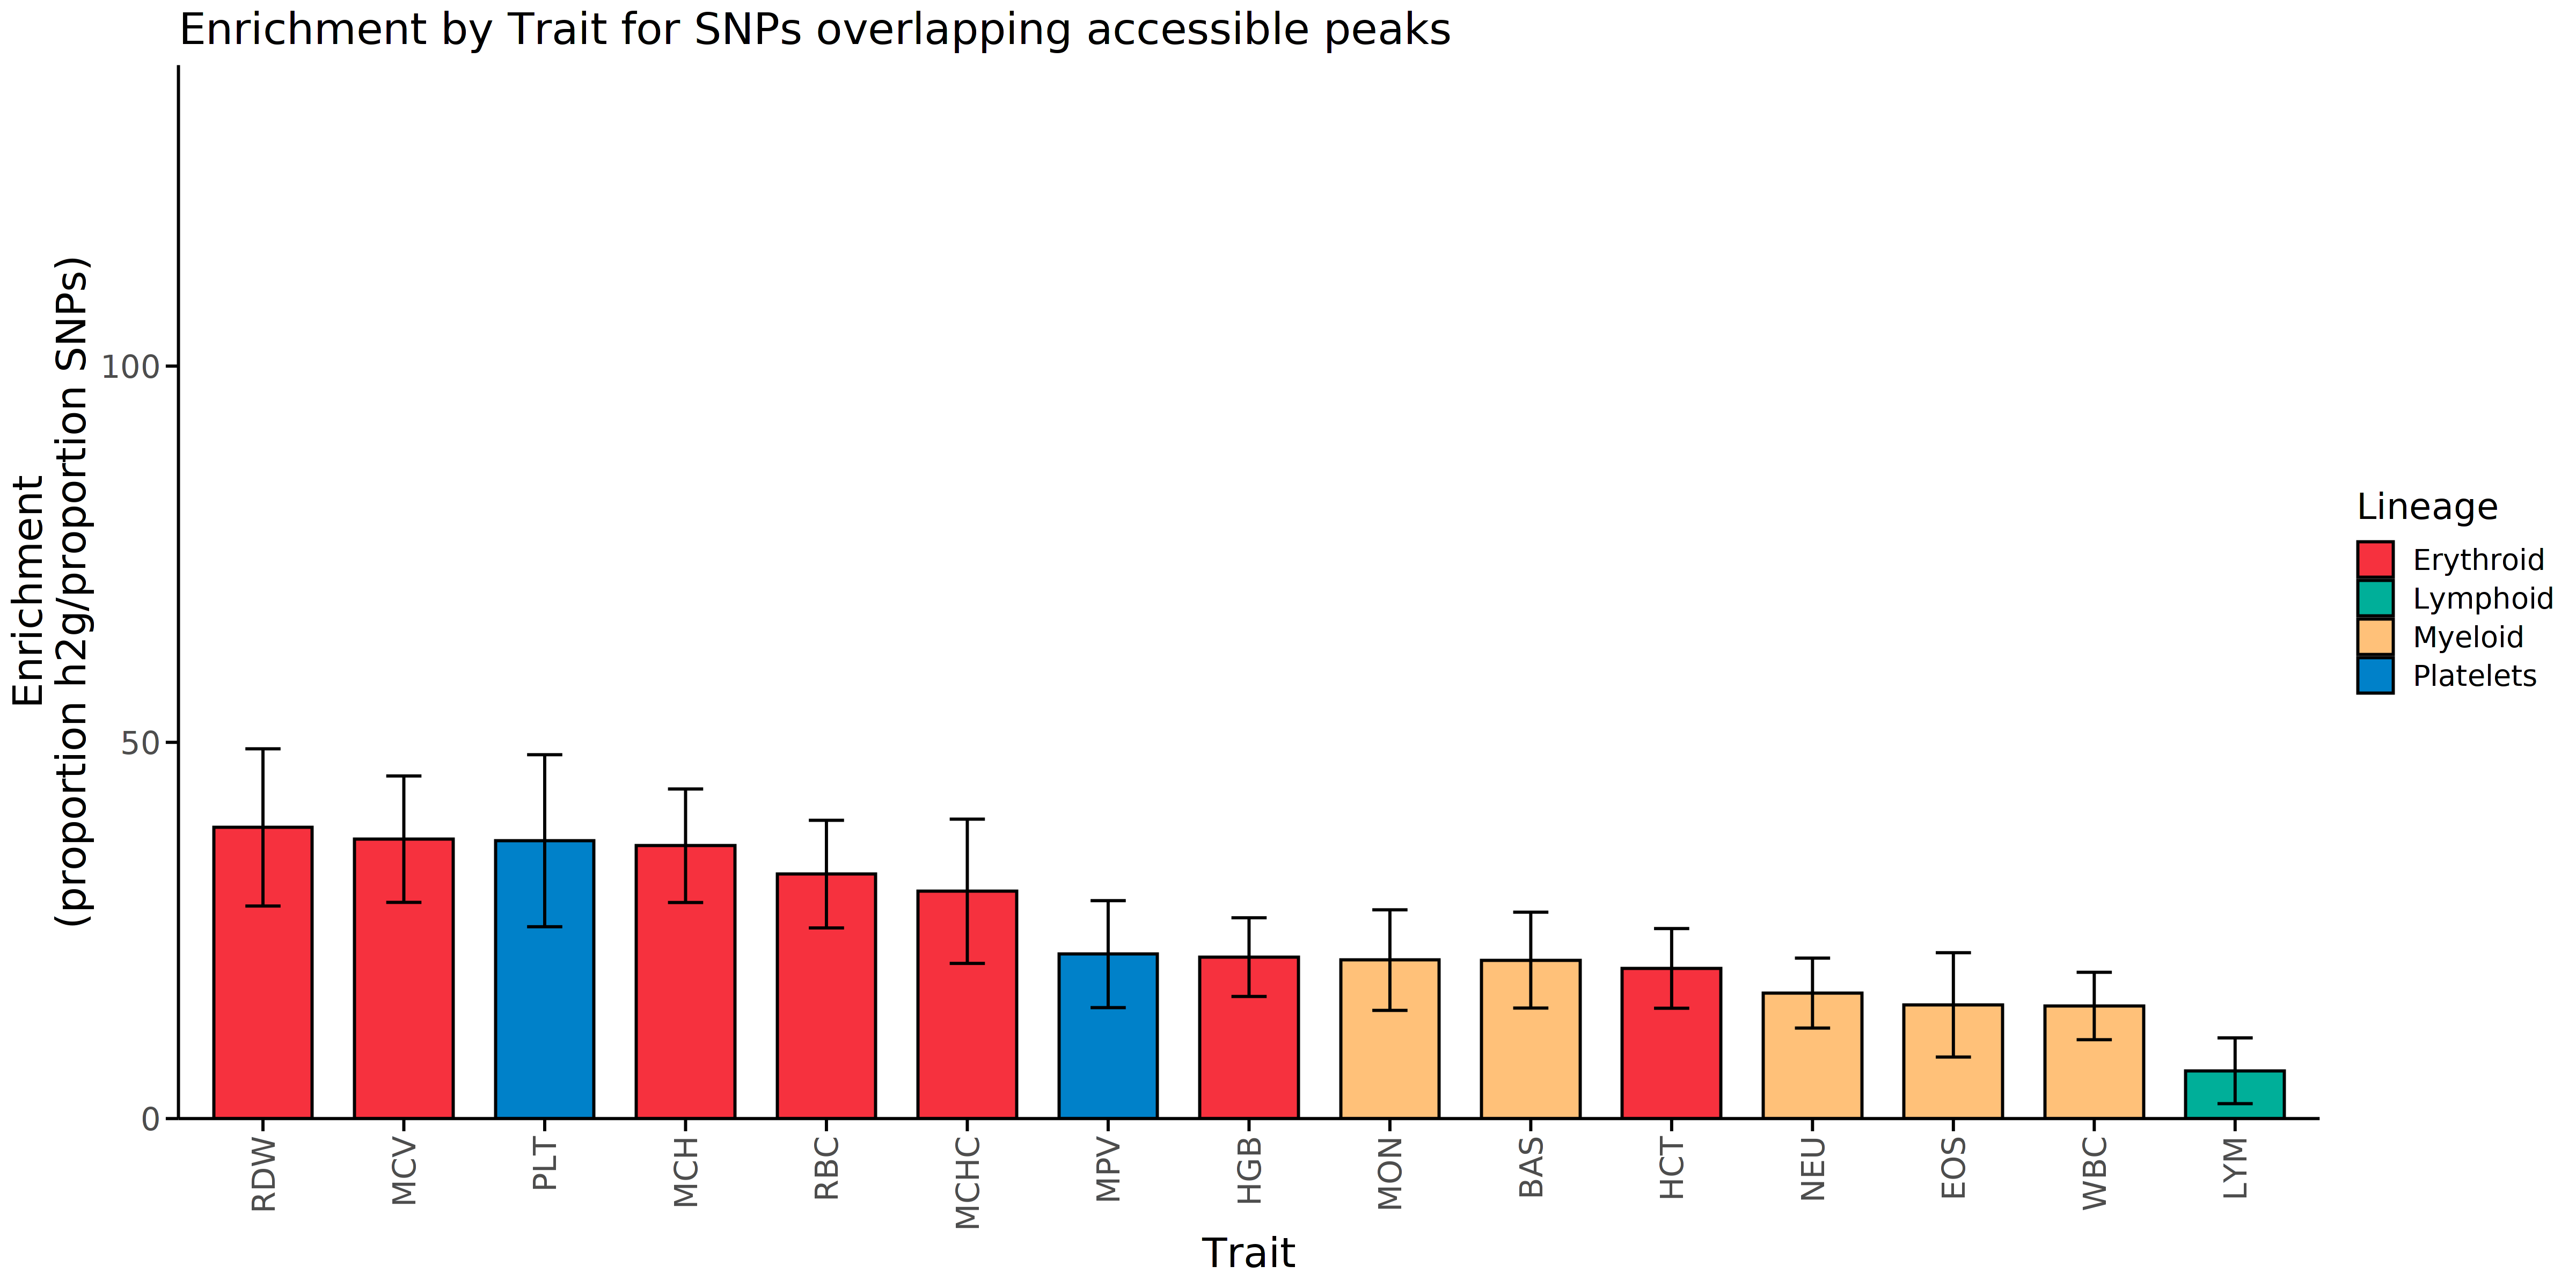

In [28]:
width=16
height=8
figure_name='UNIQUE_mixscale_TF_sensitive_NOT_IN_palantir_NT_cells.pdf'
options(repr.plot.width = width, repr.plot.height = height, repr.plot.res = 300)

data=read.table("/output/path/post_ldsc_files_3/ldsc_analysis_UNIQUE_TF_sensitive_NOT_IN_peaks_correlated_with_erythroid_differentiation_extracted_data.csv",sep=',',header=TRUE)
library(ggplot2)
library(dplyr)
library(BuenColors)


colnames(data)[1]='Trait'
colnames(data)[2]='Enrichment_2'
colnames(data)[3]='Enrichment_se'

data$Lineage <- ifelse(grepl('LYM', data$Trait), 'Lymphoid',
                  ifelse(grepl('RBC|HGB|HCT|MCH|MCV|MCHC|RDW', data$Trait), 'Erythroid',
                  ifelse(grepl('WBC|NEU|MON|BAS|EOS', data$Trait), 'Myeloid',
                  ifelse(grepl('PLT|MPV', data$Trait), 'Platelets', 'Unknown'))))

responsive_order <- data %>%
  arrange(desc(Enrichment_2)) %>%
  .$Trait

data$Trait <- factor(data$Trait, levels = responsive_order)

bueno_colors <- c('Erythroid' = jdb_color_map(c("MEP")),
                  'Myeloid' = jdb_color_map(c("CMP")),
                  'Lymphoid' = jdb_color_map(c("LMPP")), 
                  'Platelets' = jdb_color_map(c("CD4")))

p <- ggplot(data, aes(x = Trait, y = Enrichment_2, fill = Lineage)) +
  geom_bar(color='black',stat = "identity", position = position_dodge(), width = 0.7) +
 geom_errorbar(aes(ymin = Enrichment_2+Enrichment_se, ymax = Enrichment_2-Enrichment_se), 
                position = position_dodge(width = 0.7), 
                width = 0.25) +
  #facet_wrap(~Perturbation_Type, dir = "v", scales = 'free_x', labeller = labeller(Perturbation_Type = c('perturbation_responsive' = 'Peaks responsive to perturbation', 'non_responsive' = 'Peaks not responsive to perturbation'))) +
  scale_fill_manual(values = bueno_colors) +
  labs(title = 'Enrichment by Trait for SNPs overlapping accessible peaks', x = 'Trait', y = 'Enrichment\n(proportion h2g/proportion SNPs)') +
  theme_minimal() +
  theme(
    text = element_text(size = 16),
    axis.title = element_text(size = 18),
    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 14),
    axis.text.y = element_text(size = 14),
    panel.background = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.ticks = element_line(color = "black", size = 0.5),  # Change color and size as needed
    axis.ticks.length = unit(2, "mm"),
    axis.line = element_line(color = "black"),
    strip.text = element_text(size = 16),
    strip.background = element_blank()
  )+ scale_y_continuous(expand = c(0, 0),limits = c(0,140))

print(p)

ggsave(paste(output_folder,figure_name,sep=""),dpi = 600, width = width, height = height)


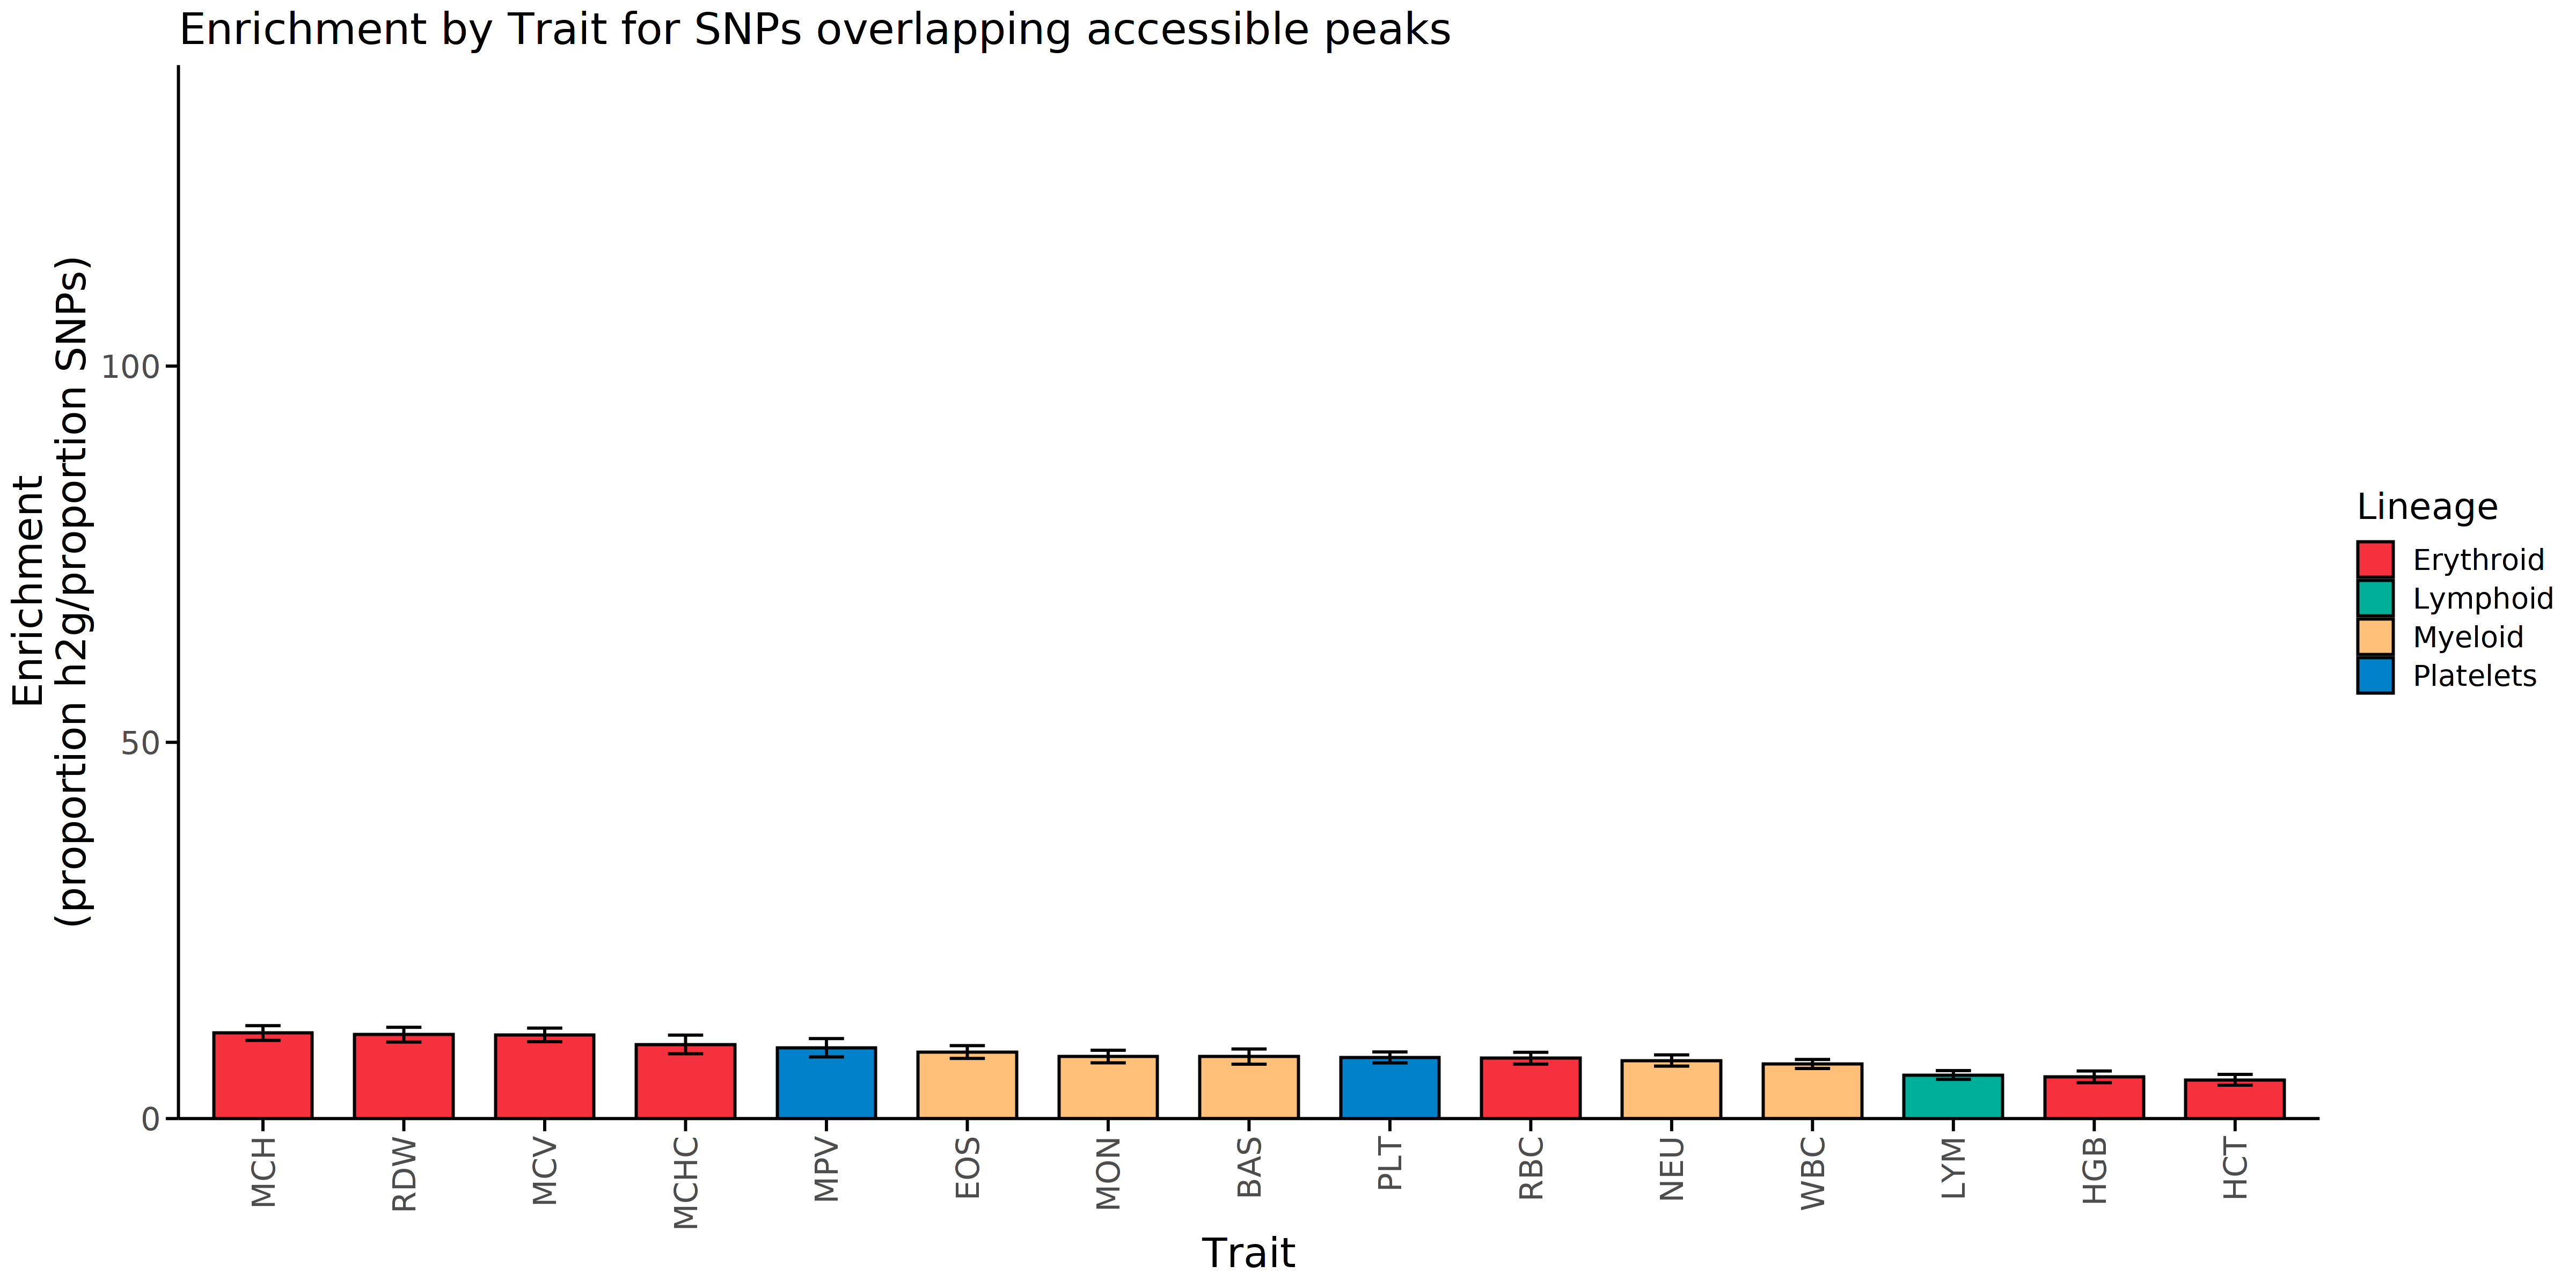

In [31]:
width=16
height=8
figure_name='ldsc_analysis_january_2024_all_peaks_NO_BASE_SNP.pdf'
options(repr.plot.width = width, repr.plot.height = height, repr.plot.res = 300)

data=read.table("/output/path/post_ldsc_files_4/ldsc_analysis_all_peaks_POST_LDSC_extracted_data.csv",sep=',',header=TRUE)
library(ggplot2)
library(dplyr)
library(BuenColors)


# Load the data
colnames(data)[1]='Trait'
colnames(data)[2]='Enrichment_2'
colnames(data)[3]='Enrichment_se'

data$Lineage <- ifelse(grepl('LYM', data$Trait), 'Lymphoid',
                  ifelse(grepl('RBC|HGB|HCT|MCH|MCV|MCHC|RDW', data$Trait), 'Erythroid',
                  ifelse(grepl('WBC|NEU|MON|BAS|EOS', data$Trait), 'Myeloid',
                  ifelse(grepl('PLT|MPV', data$Trait), 'Platelets', 'Unknown'))))

responsive_order <- data %>%
  arrange(desc(Enrichment_2)) %>%
  .$Trait

data$Trait <- factor(data$Trait, levels = responsive_order)

bueno_colors <- c('Erythroid' = jdb_color_map(c("MEP")),
                  'Myeloid' = jdb_color_map(c("CMP")),
                  'Lymphoid' = jdb_color_map(c("LMPP")), 
                  'Platelets' = jdb_color_map(c("CD4")))

p <- ggplot(data, aes(x = Trait, y = Enrichment_2, fill = Lineage)) +
  geom_bar(color='black',stat = "identity", position = position_dodge(), width = 0.7) +
 geom_errorbar(aes(ymin = Enrichment_2+Enrichment_se, ymax = Enrichment_2-Enrichment_se), 
                position = position_dodge(width = 0.7), 
                width = 0.25) +
  #facet_wrap(~Perturbation_Type, dir = "v", scales = 'free_x', labeller = labeller(Perturbation_Type = c('perturbation_responsive' = 'Peaks responsive to perturbation', 'non_responsive' = 'Peaks not responsive to perturbation'))) +
  scale_fill_manual(values = bueno_colors) +
  labs(title = 'Enrichment by Trait for SNPs overlapping accessible peaks', x = 'Trait', y = 'Enrichment\n(proportion h2g/proportion SNPs)') +
  theme_minimal() +
  theme(
    text = element_text(size = 16),
    axis.title = element_text(size = 18),
    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 14),
    axis.text.y = element_text(size = 14),
    panel.background = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.ticks = element_line(color = "black", size = 0.5),  # Change color and size as needed
    axis.ticks.length = unit(2, "mm"),
    axis.line = element_line(color = "black"),
    strip.text = element_text(size = 16),
    strip.background = element_blank()
  )+ scale_y_continuous(expand = c(0, 0),limits = c(0,140))

print(p)

ggsave(paste(output_folder,figure_name,sep=""),dpi = 600, width = width, height = height)
